### **Load libraries - Julia 1.7**

In [1]:
using Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/Documents/Github/rnc2_project`


In [2]:
using Graphs
using GraphPlot
using DataFrames, Random, Distributions, Chain
using Plots
using ProgressBars

### **Display example graph and distribution function**

<img src="prototype_graph.png" width=700 height=1000>

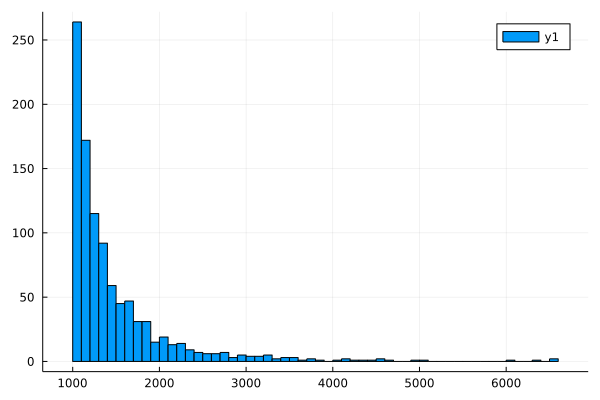

In [3]:
# representation of flow/runoff from randomised pareto distribution
α = 3
θ = 1000

Pareto(α, θ)
sample = rand(Pareto(α, θ), 1000)

histogram(sample)

### **Create functions for the different source node types**

In [4]:
function river_and_dams(dataframe)
    df = filter(:type_source => x -> (x=="river")||(x=="dam"), dataframe) # keep only type of interest
    df = innerjoin(df[:, Not([:magnitude, :time])], # join the PRESENT source with PAST target - allow to inherit magnitude paramters efficiently
                   df[:, [:target, :magnitude, :time]], 
                   on=:source=>:target)
    @. df.time += 1 # increase internal process time
    
    push!(present, df) # record edges in "present" list
end


function landslides(dataframe, delay)
    df = filter(:type_source => x -> x=="landslide", dataframe)
    # generate new landslide if time has come else wait (assume pareto probability distribution ... which is wrong and to be defined at later stage)
    @. df.magnitude = ifelse(df.time == df.global_time, rand(Pareto(3, 1000)), df.magnitude)
    # reset delay to 3 time units if time has come for a reset (assume delayed of 3 units of time to trigger landslide) or wait
    @. df.time = ifelse(df.time == df.global_time, df.time + delay, df.time)
    
    push!(present, df)
end


function catchment(dataframe, delay)
    # current catchment to river if time has come otherwise wait
    df = filter(:type_source=> x -> x=="catchment", dataframe)
    @. df.magnitude = ifelse(df.time == df.global_time, rand(Pareto(3, 1000)), df.magnitude)
    @. df.time = ifelse(df.time == df.global_time, df.time + delay, df.time)
    push!(present, df)

    # deal with the impact of catchment on rivers by cascading the runoff magnitude to rivers if time has come
    df = filter(:source => x -> x in Set(present[end].target), dataframe)
    # simulate all possible configurations of catchment/river
    df = outerjoin(df, 
                present[end], # catchment behavior
                on=:source=>:target, 
                makeunique=true)
    # if time has come (time > global time), catchment runoff to river ELSE 100 (base line value), 
    @. df.magnitude = ifelse(df.time_1 - delay == df.global_time, # due
                        df.magnitude_1, # magnitude of river is magnitude from catchment
                        100) # else magnitude is a base line value of 100 from catchment
    @. df.time += 1
    # println("df - river / catchment")
    # println(df)
    
    push!(present, df[:, [:source, :target, :type_source, :magnitude, :time, :global_time]])
end


function concatenate_results(list_dataframe)
    cat = reduce(vcat, list_dataframe) 
    gdf = groupby(cat, [:source, :target, :type_source, :time, :global_time])
    present = combine(gdf, [:magnitude] .=> sum; renamecols=false) # sum magnitude on edges to common node (have to watch the magnitude units!)
    return present
end

concatenate_results (generic function with 1 method)

### **Time algorithm**

In [5]:
# set up inital input parameters with (semi) random magnitudes
network = DataFrame(source = ["river1", "river2", "river3", "river4", "river5",
"dam", "river6", "river7", "river8", "river9",
"landslide", "landslide", "river8", "catchment1", "catchment2"], 
target = ["river2", "river3", "river4", "river5",
"dam", "river6", "river7", "river8", "river9", "river10",
"river9", "infrastructure", "infrastructure", "river1", "river2"],
type_source= ["river", "river", "river", "river", "river",
"dam", "river", "river", "river", "river",
"landslide", "landslide", "river", "catchment", "catchment"],
magnitude = [1001.0, 1002.0, 1003.0, 1004.0, 1005.0, 1006.0, 1007.0, 1008.0, 1009.0, 1010.0, 0.0, 0.0, 1009.0, 0.0, 0.0])

global_time = 1
@. network.time = global_time
@. network.global_time = global_time

network

,source,target,type_source,magnitude,time,global_time
,String,String,String,Float64,Int64,Int64
1,river1,river2,river,1001.0,1,1
2,river2,river3,river,1002.0,1,1
3,river3,river4,river,1003.0,1,1
4,river4,river5,river,1004.0,1,1
5,river5,dam,river,1005.0,1,1
6,dam,river6,dam,1006.0,1,1
7,river6,river7,river,1007.0,1,1
8,river7,river8,river,1008.0,1,1
9,river8,river9,river,1009.0,1,1


In [6]:
# Algorithm #################################
clock = []# will be used to record the time, magnitude of events on the different edges 
push!(clock, network)# add initial state to the records

@time for global_time in 1:87600 #(10 years in hours)

    # println("global time : $global_time")

    global present = [] # empty list to store present 
    past = clock[end]
    @. past.global_time = global_time

    river_and_dams(past)
    landslides(past, 3)
    catchment(past, 10)
    
    present = concatenate_results(present)

    push!(clock, present)
    
end

 32.980955 seconds (157.44 M allocations: 9.670 GiB, 4.60% gc time, 16.76% compilation time)


In [7]:
clock

87601-element Vector{Any}:
 15×6 DataFrame
 Row │ source      target          type_source  magnitude  time   global_time 
     │ String      String          String       Float64    Int64  Int64       
─────┼────────────────────────────────────────────────────────────────────────
   1 │ river1      river2          river           1001.0      1            1
   2 │ river2      river3          river           1002.0      1            1
   3 │ river3      river4          river           1003.0      1            1
   4 │ river4      river5          river           1004.0      1            1
   5 │ river5      dam             river           1005.0      1            1
   6 │ dam         river6          dam             1006.0      1            1
   7 │ river6      river7          river           1007.0      1            1
   8 │ river7      river8          river           1008.0      1            1
   9 │ river8      river9          river           1009.0      1            1
  10 │ river9     